### Load data
Downloading each article category in KalimatCorpus-2.0 from sourceforge.net
- Each category is in a folder, with all articles as .txt
- All articles are written words each in a line

In [142]:
import os
import multiprocessing.dummy as mp

In [143]:
kalimat_base = "data/KalimatCorpus-2.0"
expected_dirs = os.listdir(kalimat_base)

#### Checking for the existence of the directories

In [144]:
def check_kalimat_structure_os():
    missing = [d for d in expected_dirs if not os.path.isdir(os.path.join(kalimat_base, d))]
    
    if missing:
        print(f"❌ Missing folders: {missing}")
    else:
        count = 0
        for d in expected_dirs:
            folder_path = os.path.join(kalimat_base, d)
            count += len([f for f in os.listdir(folder_path)])
        print(f"✅ Kalimat Corpus is ready with {count} .txt files")

check_kalimat_structure_os()

✅ Kalimat Corpus is ready with 18256 .txt files


#### `load_kalimat_articles`
We went through each folder `category` pass it to `load_kalimat_articles`. 
This function will read all the articles, append them to articles list with the following information:
- `category`: the name of the folder
- `filename`: the name of the file
- `text`: the content of the article
- `text_length`: the length of the article in characters
- `word_count`: the number of words in the article

In [145]:
def load_kalimat_articles(category):
    category_path = os.path.join(kalimat_base, category)
    if not os.path.isdir(category_path):
        print(f"❌ Category '{category}' does not exist in the Kalimat Corpus.")
        return []

    articles = []
    for filename in os.listdir(category_path):
        if filename.endswith(".txt"):
            file_path = os.path.join(category_path, filename)
            with open(file_path, 'r', encoding='utf-8') as f:
                words = [line.strip() for line in f if line.strip()]
                text = " ".join(words)
                articles.append({
                    "category": category.replace("articles", "").upper(),
                    "filename": filename,
                    "text": text,
                    "text_length": len(text),
                    "word_count": len(words)
                })

    print(f"✅ Loaded {len(articles)} articles from category '{category}'")
    return articles

Parellalize the loading of articles using `multiprocessing` to speed up the process.

Then in `dataset` we flat the list of articles to one array instead of a list of lists.

In [146]:
def load_all_articles_parallel():
    with mp.Pool(processes=min(len(expected_dirs), int(os.cpu_count() / 2))) as pool:
        results = pool.map(load_kalimat_articles, expected_dirs)
    
    dataset = [article for category_articles in results for article in category_articles]
    return dataset

`if __name__ == "__main__"` is Important to solve an issue in Windows OS with `multiprocessing` module.

In [147]:
if __name__ == "__main__":
    dataset = load_all_articles_parallel()
    print(f"✅ Dataset loaded with {len(dataset)} articles.")

✅ Loaded 1689 articles from category 'articlesInternational'
✅ Loaded 2495 articles from category 'articlesCulture'
✅ Loaded 3265 articles from category 'articlesEconomy'
✅ Loaded 3237 articles from category 'articlesLocal'
✅ Loaded 3475 articles from category 'articlesReligion'
✅ Loaded 4095 articles from category 'articlesSports'
✅ Dataset loaded with 18256 articles.


### Preprocessing
Say Hello to pandas!

We will start by constructing a DataFrame from the dataset list of dictionaries.

In [172]:
import pandas as pd
df = pd.DataFrame(dataset)
df.head(), df['category'].value_counts()

(  category             filename  \
 0  CULTURE     culturecapr1.txt   
 1  CULTURE  culturecapr1005.txt   
 2  CULTURE  culturecapr1006.txt   
 3  CULTURE  culturecapr1007.txt   
 4  CULTURE  culturecapr1008.txt   
 
                                                 text  text_length  word_count  
 0  كتب سالم الرحبي : تنطلق اليوم الدورة البرامجية...        15739        2732  
 1  كتب - فيصل العلوي : شاركت السلطنة صباح امس دول...         5057         835  
 2  اربعة عروض على مسرح الشباب وعرض في الرستاق ثم ...         3892         691  
 3  حاوره خالد عبداللطيف : حين يناقش الموضوع الثقا...        11757        1972  
 4  افتتح صباح أمس بقاعة الموسيقي في جامعة السلطان...         1946         329  ,
 category
 SPORTS           4095
 RELIGION         3475
 ECONOMY          3265
 LOCAL            3237
 CULTURE          2495
 INTERNATIONAL    1689
 Name: count, dtype: int64)

#### Setup necessary libraries
- `nltk` for text processing
- `nltk.corpus.stopwords` for stop words
- `regex`

Then downloading the stop words using `nltk.download()` function.
- `stopwords` is a list of common words that are not useful for text analysis (e.g. "في", "من", "إلى", "على", "و")


In [173]:
import nltk
from nltk.corpus import stopwords
import regex as re

nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sauda\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Adding additional stopwords based on our analysis of the corpus

In [174]:
arabic_stopwords = set(stopwords.words('arabic'))
stemmer = nltk.stem.ISRIStemmer() # Worsen the results
for word in ['في', 'ان', 'ان', 'الى', 'او', 'فى']: arabic_stopwords.add(word)
print(f"Stop words count: {len(arabic_stopwords)}")

Stop words count: 705


#### `preprocess_text`
We applied `preprocess_text` to clean and normalize the Arabic text before modeling.  
This function performs the following steps:
- **Remove** punctuation, digits (Arabic and English), and English letters.
- **Normalize** Arabic letters by unifying variants (e.g., "أ", "إ", "آ" → "ا").
- **Remove** Arabic diacritics and extra whitespace.
- **Tokenize** the text and **remove** Arabic stopwords.
- Finally, **join** the tokens back into a cleaned string.

In [175]:
def preprocess_text(text):

    text = re.sub(r'\p{P}+|\$', '', text)  # remove all punctuation (English + Arabic)
    text = re.sub(r'[0-9٠-٩]', '', text)  # remove Arabic and English digits
    text = re.sub(r'[a-zA-Z]', '', text)  # remove English letters
    text = re.sub(r'[اآإأ]', 'ا', text)  # replace Arabic letter with hamza with 'ا'
    text = re.sub(r'[\u064B-\u0652]', '', text)  # remove Arabic diacritics
    text = re.sub(r'\s+', ' ', text).strip()  # clean extra spaces

    tokens = text.split()
    tokens = [stemmer.stem(word) for word in tokens if word not in arabic_stopwords]


    return ' '.join(tokens)

preprocess_text("!مرحباً... هذا نَصٌّ تَجْرِيبِيٌ يحتوي على 123 أرقام ٤٥٦، في علامات ترقيم @#$%، كلمات إنجليزية like This.")

'رحب نص جرب حوي رقم علم رقم كلم انجليزية'

Now we can apply the `preprocess_text` function to the DataFrame creating a new column `processed_text`

In [176]:
df['processed_text'] = df['text'].apply(preprocess_text)

### Visualization

In [177]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from collections import Counter
import arabic_reshaper
from bidi.algorithm import get_display
%matplotlib inline

fm.fontManager.addfont('arial-unicode-ms.ttf')
arabic_font = fm.FontProperties(fname='arial-unicode-ms.ttf')

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = arabic_font.get_name()

               Unique  Duplicate
category                        
CULTURE          2435         60
ECONOMY          3202         63
INTERNATIONAL    1624         65
LOCAL            3043        194
RELIGION           57       3418
SPORTS           4035         60


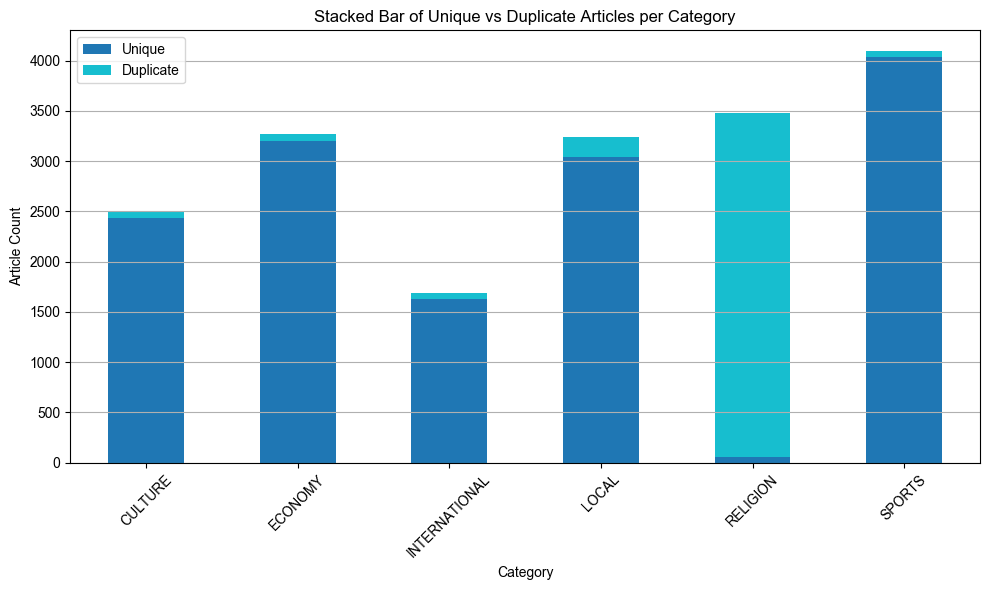

In [178]:
df['is_duplicate'] = df.duplicated(subset='processed_text', keep=False)

# Group and make sure both True/False appear
counts = df.groupby(['category', 'is_duplicate']).size().unstack().reindex(columns=[False, True], fill_value=0)
counts.columns = ['Unique', 'Duplicate']
print(counts)
# Plot
counts.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='tab10')
plt.title("Stacked Bar of Unique vs Duplicate Articles per Category")
plt.xlabel("Category")
plt.ylabel("Article Count")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


#### 1- Stacked Bar: Unique vs Duplicate Articles per Category
While most categories have a healthy distribution of unique articles, the `RELIGION` category has a significant number of duplicate articles. This could bias classification models if not properly handled.

In [179]:
df = df.drop_duplicates(subset=['processed_text'])

#### 2- Vocabulary Size
After preprocessing, the corpus contains ~235k unique words. Such size will impact the dimensionality of the feature extraction methods like TF-IDF.

In [180]:
vocab = set()
df['processed_text'].str.split().apply(vocab.update)
len(vocab)

33336

#### 3- Top 20 Most Common Words (Bar Chart)
The most frequent words in the corpus. we can see "السلطنة" which make sense as the corpus if of Omani articles.

In [183]:
word_counts = Counter()
_ = df['processed_text'].str.split().apply(word_counts.update)


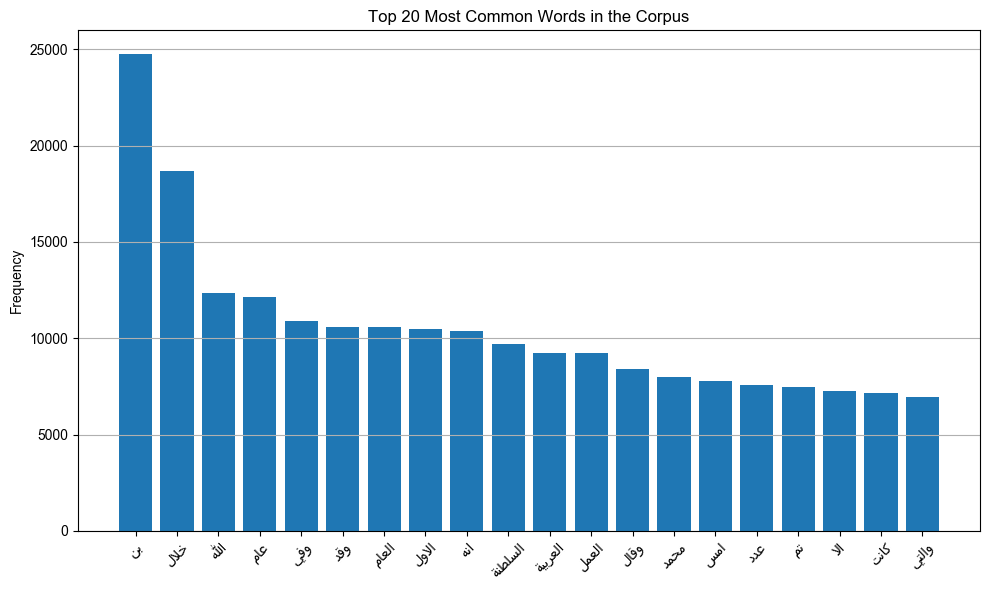

In [158]:
common_words = word_counts.most_common(20)

words, counts = zip(*common_words)
display_words = list(map(get_display, map(arabic_reshaper.reshape, words)))
plt.figure(figsize=(10, 6))
plt.bar(display_words, counts)
plt.title("Top 20 Most Common Words in the Corpus")
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

#### 4- Article Word Counts per Category (Box Plot)
The median article length is different across categories. `RELIGION` articles tend to be longer on average, while `SPORTS` articles are shorter.

<Figure size 1200x600 with 0 Axes>

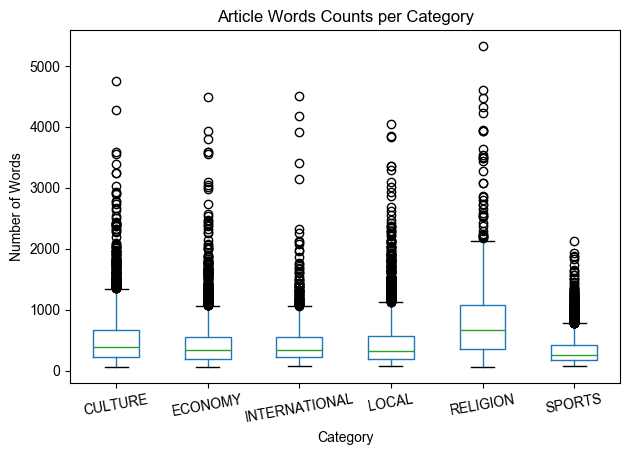

In [159]:
plt.figure(figsize=(12,6))
df.boxplot(column='word_count', by='category', grid=False, rot=10)
plt.title('Article Words Counts per Category') 
plt.suptitle('')  # Remove the automatic "Boxplot grouped by" title
plt.xlabel('Category')
plt.ylabel('Number of Words')
plt.tight_layout()
plt.show()

#### 5- Top 20 Bigrams (Horizontal Bar Chart)
Common bigrams such as "السلطان قابوس","بن سعيد", and "محمد بن" appear frequently in the corpus, Capturing common word expressions in Omani journalism.

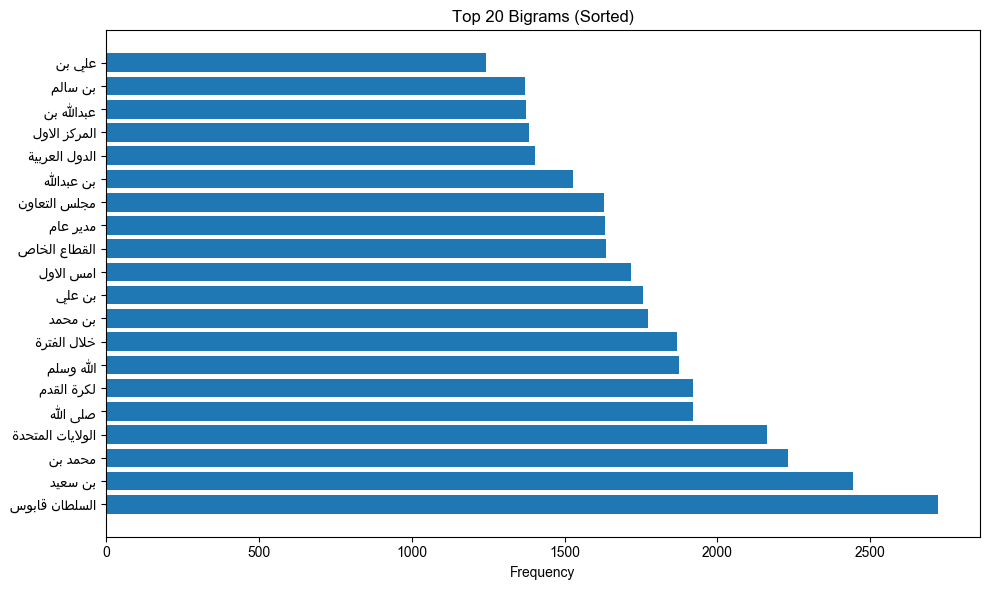

In [160]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(ngram_range=(2,2), max_features=20)
X = vectorizer.fit_transform(df['processed_text'])
bigrams = vectorizer.get_feature_names_out()

counts = X.sum(axis=0).A1
display_words = list(map(get_display, map(arabic_reshaper.reshape, bigrams)))

bigrams_counts = list(zip(display_words, counts))
bigrams_counts.sort(key=lambda x: x[1], reverse=True)
sorted_display_words, sorted_counts = zip(*bigrams_counts)
# Plot
plt.figure(figsize=(10,6))
plt.barh(sorted_display_words, sorted_counts)
plt.title('Top 20 Bigrams (Sorted)')
plt.xlabel('Frequency')
plt.tight_layout()
plt.show()


In [161]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
tfidf_matrix = tfidf_vectorizer.fit_transform(df['processed_text'])

In [162]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

X = tfidf_matrix
y = df['category']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

rf_classifier = RandomForestClassifier(n_estimators=260, random_state=42, n_jobs=-1)


rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_test)
cv_scores = cross_val_score(rf_classifier, X, y, cv=5, scoring='accuracy')

print(f'\nCross-Validation Scores: {cv_scores}')
print(f'Mean Cross-Validation Score: {np.mean(cv_scores):.4f}')

print("\n Model Evaluation")
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

print("\nClassification Report:")
class_report = classification_report(y_test, y_pred, target_names=sorted(y.unique()))
print(class_report)



Cross-Validation Scores: [0.86809917 0.88099174 0.88029101 0.90079365 0.89583333]
Mean Cross-Validation Score: 0.8852

 Model Evaluation
Accuracy: 0.900495867768595

Classification Report:
               precision    recall  f1-score   support

      CULTURE       0.89      0.86      0.87       493
      ECONOMY       0.89      0.85      0.87       647
INTERNATIONAL       0.90      0.92      0.91       331
        LOCAL       0.82      0.87      0.85       628
     RELIGION       0.90      0.82      0.86       112
       SPORTS       0.98      0.99      0.99       814

     accuracy                           0.90      3025
    macro avg       0.90      0.89      0.89      3025
 weighted avg       0.90      0.90      0.90      3025



### Tryign with\out duplicates
- without diplicates + no religion :
Mean Cross-Validation Score: 0.8919
accuracy                           0.91      2913
- without diplicates with religion:
Mean Cross-Validation Score: 0.8871
accuracy                           0.90      3025
- with no duplicates with religion:
Mean Cross-Validation Score: 0.8978
accuracy                           0.92      3652
